This notebook aims at **testing the two-layer Arctic hypothesis**. We expected the surface current in the main Arctic (Canada Basin + Makarov Basin) goes in cyclonic way and anti-cyclonic in deeper layer.

Therefore, this notebook plots the surface layer and the salinity maximum layer to see whether the hypothesis is right or not. 

**Conclusion: The surface current is not going in a cyclonic way. Have to say this hypothesis is not right at the first place..:(. But the good news is that the simulated flow is very closed to the geostrophic pattern, which means 'geostrophic flow' might be the answer to our original question - why the flow goes in an anti-cyclonic way.**

In [48]:
import copy,os,glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
from ArcticTools import hovmoller as hov
from ArcticTools import geostropic as geo
% matplotlib inline

In [49]:
import importlib
importlib.reload(geo)

<module 'ArcticTools.geostropic' from '/ocean/xiaoxiny/research/tools/ArcticTools/geostropic.py'>

In [50]:
with nc.Dataset(sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc'))[0]) \
as ptrc:
    nav_lon = ptrc.variables['nav_lon'][:,:]
    nav_lat = ptrc.variables['nav_lat'][:,:]
    dep  =  ptrc.variables['deptht'][:]


tmask = nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy = tmask.variables['mbathy'][0,400:,:]
tmask = tmask.variables['tmask'][0,:,400:,:]


bathy = nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = bathy.variables['Bathymetry'][400:,:]

In [51]:
uvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
vvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

/ocean/xiaoxiny/research/tools/ArcticTools/hovmoller.py:50: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  lon = x_lon[a,b]
/ocean/xiaoxiny/research/tools/ArcticTools/hovmoller.py:51: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  lat = y_lat[a,b]


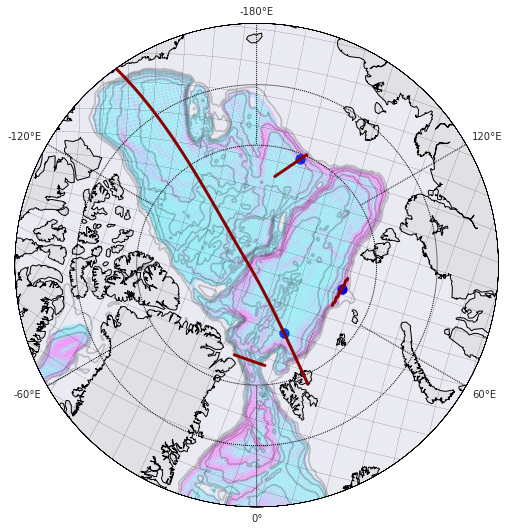

In [59]:
# test functions above
fig  =  plt.figure(figsize = (13/1.5,13/1.5))
ax  =  fig.add_subplot()
m,x_lon,y_lat = hov.mapping(70)

#sec1 Makarov
x_mb,y_mb,a_mb,b_mb = hov.section(x0 = -130,y0 = 300,length = 20,xi = 1,yi = 1, x_lon=x_lon, y_lat=y_lat)
m.plot(a_mb[:],b_mb[:],color = 'darkred',linewidth = 3)
#m.scatter(a_mb[15],b_mb[15],color = 'darkred',linewidth = 3)
m.scatter(a_mb[-5],b_mb[-5], s=100)

#sec2 Nansen
x_ns,y_ns,a_ns,b_ns = hov.section(x0 = -210,y0 = 368,length = 25,xi = 1,yi = 0.2, x_lon=x_lon, y_lat=y_lat)
m.plot(a_ns[:],b_ns[:],color = 'darkred',linewidth = 3)
m.scatter(a_ns[-10],b_ns[-10], s=100)
#m.scatter(a_ns[15],b_ns[15],color = 'darkred',linewidth = 3)


#sec3 CB
x_cb,y_cb,a_cb,b_cb = hov.section(x0 = 330,y0 = 170,length = 100,xi = -2,yi = 2, x_lon=x_lon, y_lat=y_lat)
m.plot(a_cb[:],b_cb[:],color = 'darkred',linewidth = 3)
m.scatter(a_cb[-15],b_cb[-15], s=100)


#sec4 Fram strait 
x_fs,y_fs,a_fs,b_fs = hov.section(x0 = -265,y0 = 310,length =25 ,xi = 0 ,yi = 1, x_lon=x_lon, y_lat=y_lat)
m.plot(a_fs[:],b_fs[:],color = 'darkred',linewidth = 3)
#m.scatter(a_fs[15],b_fs[15],color = 'darkred',linewidth = 3)

# plot one velocity snapshot, make sure my profile is not far away from the pathway
data  = (uvel.variables['vozocrtx'][5,35,400:,:]**2 + vvel.variables['vomecrty'][5,35,400:,:]**2)**0.5
m.pcolor(x_lon,y_lat,data[:,:],cmap = 'cool',vmax = 0.04, alpha = 0.1)

In [53]:
def section_hovmoller(indexa,indexb,data,layer,tmask, nav_lon):
    '''load data for vertical profiles, return to tracer/cooridination 
     ================================================================
     
    arg:  data: 4-dimension model result from NEMO model 
    type: data: np.array
    
    arg:  layer: for a desired depth of the field
    type: layer: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger   
    
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger

    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will Round to nearest integer)

    '''
    temp = np.zeros((data.shape[0],layer, len(indexa)))
    for i in range (layer):
        temp[:,i,...] = data[:,i,indexa,indexb]
        for k in range (data.shape[0]):
            temp[k,i,...][tmask[i,indexa,indexb] == 0] = np.nan

    coordinate = nav_lon[indexa,indexb]
    return temp,coordinate


def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
        data [tmask == 0] = np.nan
    return data

# s & T at the scatter point

In [54]:
# preprae data -- t
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('T',T=i+2002,tmask= tmask, ENG='exh001', key = '_t_')
    Temp[i,...]=data
    
temp,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


# preprae data -- s
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('S',T=i+2002,tmask= tmask, ENG='exh001', key = '_s_')
    Temp[i,...]=data
salinity,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


# preprae data -- u
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= load_v('U',T=i+2002,tmask= tmask, ENG='EXH001', key = 'U')
    Temp[i,...]=data
    
u,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)

# preprae data -- v
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= load_v('V',T=i+2002,tmask= tmask, ENG='EXH001', key = 'V')
    Temp[i,...]=data
v,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)



Take a  look at the vertical profile at the scatter point:

# ANNA

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


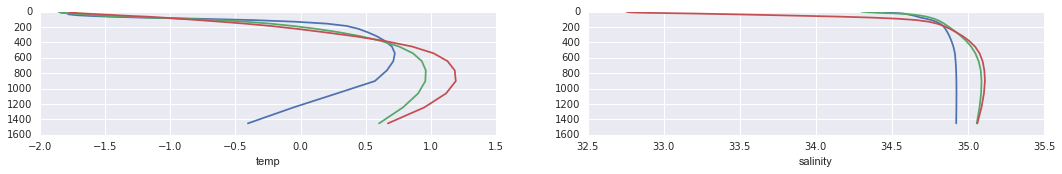

In [65]:
import seaborn as sns
# preprae data -- t
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('T',T=i+2002,tmask= tmask, ENG='exh001', key = '_t_')
    Temp[i,...]=data
    
temp,coor = section_hovmoller(indexa=x_ns,indexb=y_ns,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


# preprae data -- s
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('S',T=i+2002,tmask= tmask, ENG='exh001', key = '_s_')
    Temp[i,...]=data
salinity,coor = section_hovmoller(indexa=x_ns,indexb=y_ns,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


fig  =  plt.figure(figsize = (18,9/1.2))
ax = plt.subplot(3,2,1)
for i in [0,8,11]:
    plt.plot(np.ma.masked_invalid(temp[i,:45.,-15]),dep[:45]) #[0,...] means 
plt.gca().invert_yaxis()
plt.xlabel('temp')

ax = plt.subplot(3,2,2)
for i in [0,8,11]:
    plt.plot(np.ma.masked_invalid(salinity[i,:45.,-15]),dep[:45])
plt.gca().invert_yaxis()
plt.xlabel('salinity')

# close to Fram stait

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


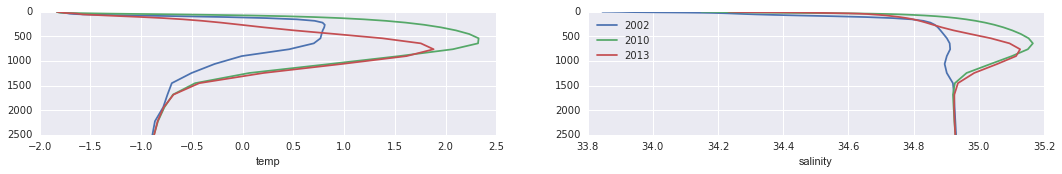

In [63]:
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('T',T=i+2002,tmask= tmask, ENG='exh001', key = '_t_')
    Temp[i,...]=data
    
temp,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


# preprae data -- s
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('S',T=i+2002,tmask= tmask, ENG='exh001', key = '_s_')
    Temp[i,...]=data
salinity,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)



for loc in [-10]:
    fig  =  plt.figure(figsize = (18,9/1.2))
    ax = plt.subplot(3,2,1)
    for i in [0,8,11]:
        plt.plot(np.ma.masked_invalid(temp[i,:50.,loc]),dep[:50]) #[0,...] means 
    plt.ylim(0,2500)    
    plt.gca().invert_yaxis()
    plt.xlabel('temp')

    ax = plt.subplot(3,2,2)
    for i in [0,8,11]:
        plt.plot(np.ma.masked_invalid(salinity[i,:50.,loc]),dep[:50],label=i+2002)
    plt.ylim(0,2500)
    plt.gca().invert_yaxis()
    plt.xlabel('salinity')
    plt.legend(loc=0)

# MB

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


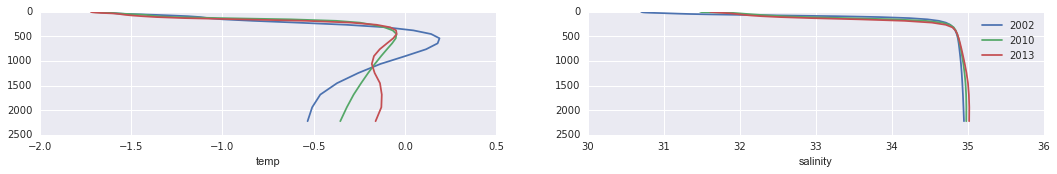

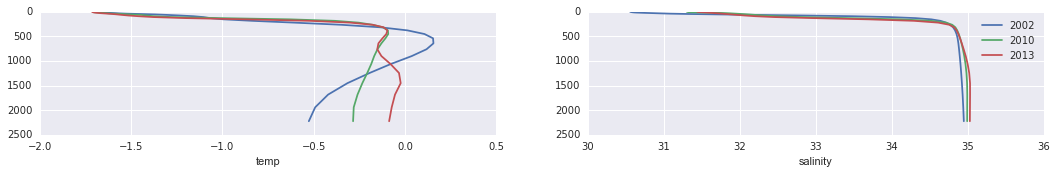

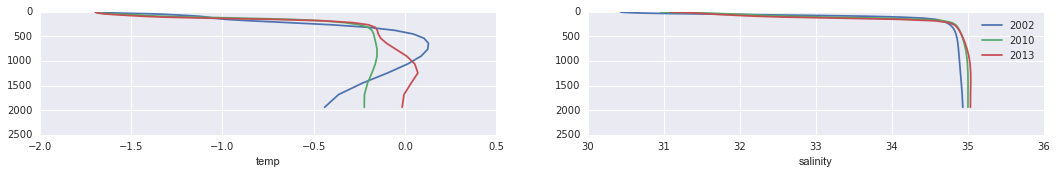

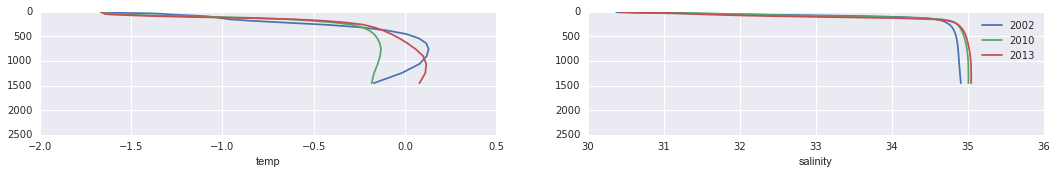

In [56]:
# preprae data -- t
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('T',T=i+2002,tmask= tmask, ENG='exh001', key = '_t_')
    Temp[i,...]=data
    
temp,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)


# preprae data -- s
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('S',T=i+2002,tmask= tmask, ENG='exh001', key = '_s_')
    Temp[i,...]=data
salinity,coor = section_hovmoller(indexa=x_mb,indexb=y_mb,data=Temp,layer=50,tmask=tmask, nav_lon=nav_lon)
#=============================================

for loc in range (-5,-1):
    fig  =  plt.figure(figsize = (18,9/1.2))
    ax = plt.subplot(3,2,1)
    for i in [0,8,11]:
        plt.plot(np.ma.masked_invalid(temp[i,:50.,loc]),dep[:50]) #[0,...] means 
    plt.ylim(0,2500)    
    plt.gca().invert_yaxis()
    plt.xlabel('temp')

    ax = plt.subplot(3,2,2)
    for i in [0,8,11]:
        plt.plot(np.ma.masked_invalid(salinity[i,:50.,loc]),dep[:50],label=i+2002)
    plt.ylim(0,2500)
    plt.gca().invert_yaxis()
    plt.xlabel('salinity')
    plt.legend()
   

In [42]:
print ('temp maximum: layer %s, depth %s'%(temp[-1,:50.,-3].argmax(),dep[temp[-1,:50.,-3].argmax()]))
print ('salinity maximum: layer %s, depth %s'%(salinity[-1,:50.,-3].argmax(),dep[salinity[-1,:50.,-3].argmax()]))

temp maximum: layer 40, depth 2225.08
salinity maximum: layer 40, depth 2225.08


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Trying to see what the u and v look like in temp maiximum layer

In [43]:
# grid for plotting
x1d=np.linspace(0,nav_lon[:,0].shape[0],nav_lat[:,0].shape[0])
y1d=np.linspace(0,nav_lon[0,:].shape[0],nav_lat[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

Blow: test function that finds the salinity maximum layer

In [44]:
# assign t-maximum layer to one array
temp= hov.load_ts('T',T=2002,tmask= tmask, ENG='exh001', key = '_t_')
layer= np.zeros_like(nav_lon)
for i in range (layer.shape[0]):
    for j in range (layer.shape[1]):
        layer[i,j] = temp[:45,i,j].argmax()
        

In [45]:
temp= hov.load_ts('T',T=2014,tmask= tmask, ENG='exh001', key = '_t_')
layer2014= np.zeros_like(nav_lon)
for i in range (layer2014.shape[0]):
    for j in range (layer2014.shape[1]):
        layer2014[i,j] = temp[:45,i,j].argmax()

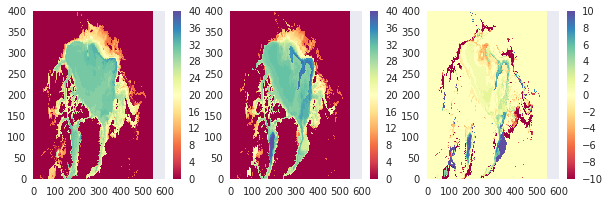

In [46]:
# visualize t-maximum layer
fig=plt.figure(figsize=(10,3))
plt.subplot(131)
plt.pcolor(layer, cmap='Spectral',vmin=0,vmax=40)
plt.colorbar()
plt.subplot(132)
plt.pcolor(layer2014, cmap='Spectral',vmin=0,vmax=40)
plt.colorbar()
plt.subplot(133)
plt.pcolor(layer2014-layer, cmap='Spectral',vmin=-10,vmax=10)
plt.colorbar()

lhs : 2002;  rhs:2014

# cyclonic year (2002) & anti-cyclonic(2014)  -- salinity maximum layer


> green arrows are goestrophic flow/ black arrows are flows from model. (They have the same scale.)


# Sal.

In [30]:
def load_smax(year,layer):

    # assign array

    ug_0 = np.zeros_like(sal)
    vg_0 = np.zeros_like(sal)
    P_0 = np.zeros_like(sal)

    # loop over the depth dimension to get full-dimension geostrophic flow
    print ('>> loading geostrophic flow')
    for i in range (1,sal.shape[0]):
        ug_0[i,:,:],vg_0[i,:,:],P_0[i,:,:],nav_lat,nav_lon = geo.geoflow(\
            modelt=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_t_year%s.nc'%year),
            models=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_s_year%s.nc'%year),
            modelssh=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%year),
            layer=i,ssh_key = 'True',detail = 'False')

    # load u, v, t, s
    print ('>> loading u, v, t, s')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')
    t= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    s= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')

    # set up a dictionary to contain all the model result
    model={'u':u,'v':v,'ug_0':ug_0,'vg_0':vg_0,\
           't':t,'s':s}
    
    # set up an empty dictionary for latter use     
    s_max={'u':np.zeros_like(nav_lon),'v':np.zeros_like(nav_lon),\
           'ug_0':np.zeros_like(nav_lon),'vg_0':np.zeros_like(nav_lon),\
           't':np.zeros_like(nav_lon),'s':np.zeros_like(nav_lon)}


    # select data from each local s max layer
    for i in range (layer.shape[0]):
        for j in range (layer.shape[1]):
            if layer[i,j] != 0:
                for ikey in s_max.keys():
                    s_max[ikey][i,j] = model[ikey][layer[i,j],i,j]

    # mask land
    for i in s_max.keys():
        s_max[i][s_max['s'] ==0 ] = np.nan
        s_max[i]=np.ma.masked_invalid(s_max[i])
    return s_max

In [31]:
# load data for 2002 and 2014
s_max_data= {'s_max_2002':load_smax(2002,layer=layer),'s_max_2014':load_smax(2014,layer=layer2014)}

>> loading geostrophic flow
>> loading u, v, t, s


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3133: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


>> loading geostrophic flow
>> loading u, v, t, s


Plot temp. maximum layer with modeled velocity
year :2002


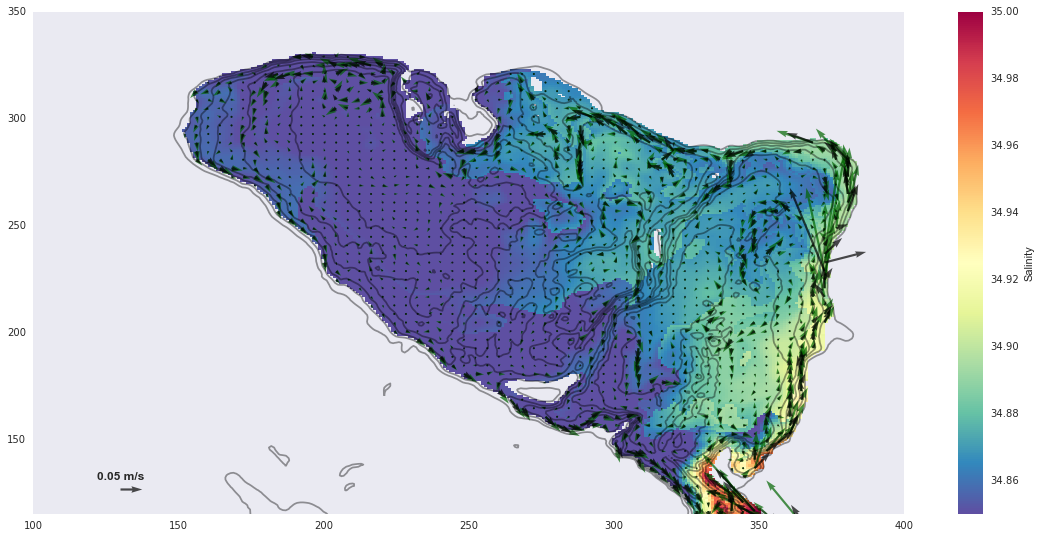

year :2014


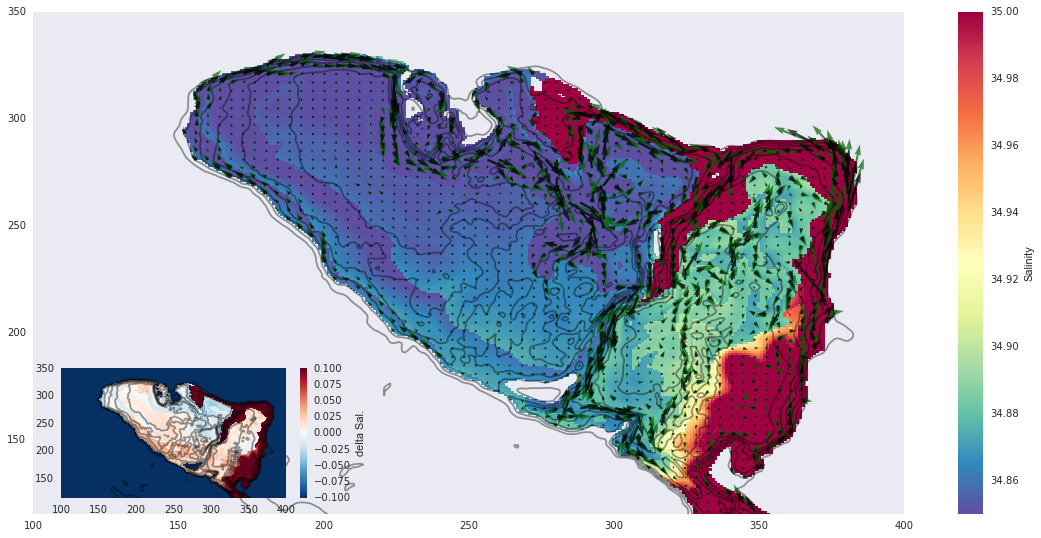

In [47]:
print ('Plot temp. maximum layer with modeled velocity')


for year,s_max, vmin,vmax,scale in zip ([2002,2014],[s_max_data['s_max_2002'],s_max_data['s_max_2014']],\
                                  [34.85,34.85],[35,35],[2,3.5]):
    print ("year :%s"%year)
    fig = plt.figure(figsize=(13*1.5,6*1.5))
    for i in s_max.keys():
        s_max[i][tmask[35,:,:]==0]=np.nan
    plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(s_max['s']),cmap='Spectral_r',
               vmin=vmin,vmax=vmax)
                #vmin=np.ma.masked_invalid(P_0[:,:]).min()+3800, vmax=np.ma.masked_invalid(P_0[:,:]).max()-100);
    cbar=plt.colorbar()
    cbar.set_label('Salinity')
    #vector

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.ma.masked_invalid(s_max['ug_0'][::4,::4]),\
                 np.ma.masked_invalid(s_max['vg_0'][::4,::4]),
                 scale=scale,width=0.0025,color='darkgreen',alpha=0.7)

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], s_max['u'][::4,::4], s_max['v'][::4,::4],
               scale=scale,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)

    if year == 2014:
        left, bottom, width, height = [0.145, 0.15, 0.2, 0.2]
        ax = fig.add_axes([left, bottom, width, height])
        im=ax.pcolor(x2d[:,:], y2d[:,:], s_max['s']-s_max_data['s_max_2002']['s'] \
                     ,vmin=-0.1,vmax=0.1,cmap='RdBu_r');
        cbar=fig.colorbar(im, ax=ax)
        cbar.set_label('delta Sal.')
        plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
        plt.ylim(115,350)    ;plt.xlim(100,400)

    plt.show()

The lower left plot shows the maximum salinity difference in the Arctic. 


# Temp. 

In 2014, significantly saltier, and warmer (see plots below) in Nansen Basin and Makarov Basin. Cooler boundary current at Alpha Ridge (see plots below).

year :2002


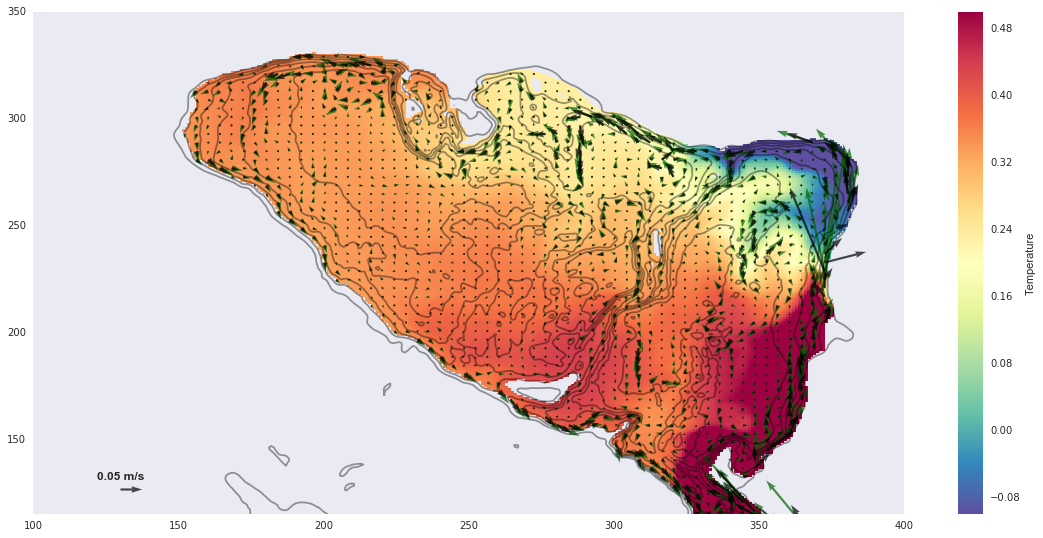

year :2014


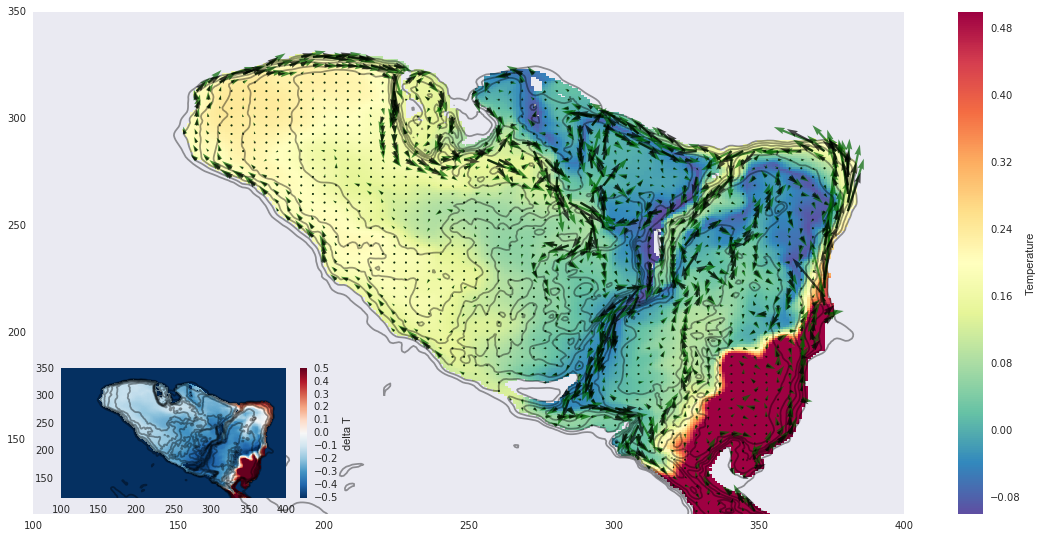

In [46]:
for year,s_max, vmin,vmax,scale in zip ([2002,2014],[s_max_data['s_max_2002'],s_max_data['s_max_2014']],\
                                  [-0.1,-0.1],[0.5,0.5],[2,3.5]):
    print ("year :%s"%year)
    fig = plt.figure(figsize=(13*1.5,6*1.5))    

    plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(s_max['t']),cmap='Spectral_r',vmin=vmin,vmax=vmax)
                #vmin=np.ma.masked_invalid(P_0[:,:]).min()+3800, vmax=np.ma.masked_invalid(P_0[:,:]).max()-100);
    cbar=plt.colorbar()
    cbar.set_label('Temperature')
    #vector

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.ma.masked_invalid(s_max['ug_0'][::4,::4]),\
                 np.ma.masked_invalid(s_max['vg_0'][::4,::4]),
                 scale=scale,width=0.0025,color='darkgreen',alpha=0.7)

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], s_max['u'][::4,::4], s_max['v'][::4,::4],
               scale=scale,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)

    if year == 2014:
        left, bottom, width, height = [0.145, 0.15, 0.2, 0.2]
        ax = fig.add_axes([left, bottom, width, height])
        im=ax.pcolor(x2d[:,:], y2d[:,:], s_max['t']-s_max_data['s_max_2002']['t'] \
                     ,vmin=-0.5,vmax=0.5,cmap='RdBu_r');
        cbar=fig.colorbar(im, ax=ax)
        cbar.set_label('delta T')
        plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
        plt.ylim(115,350)    ;plt.xlim(100,400)

    plt.show()

# cyclonic  year / anti-cyclonic year  -- only at layer 34

> green arrows are goestrophic flow/ black arrows are flows from model.

> the background contour plot is the pressure.

In [46]:
print ('Plot surface cool layer with modeled velocity')
layer = salinity[-1,:45.,-15].argmax()

Plot surface cool layer with modeled velocity


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Plot salinity maximum layer with modeled velocity
year :2002


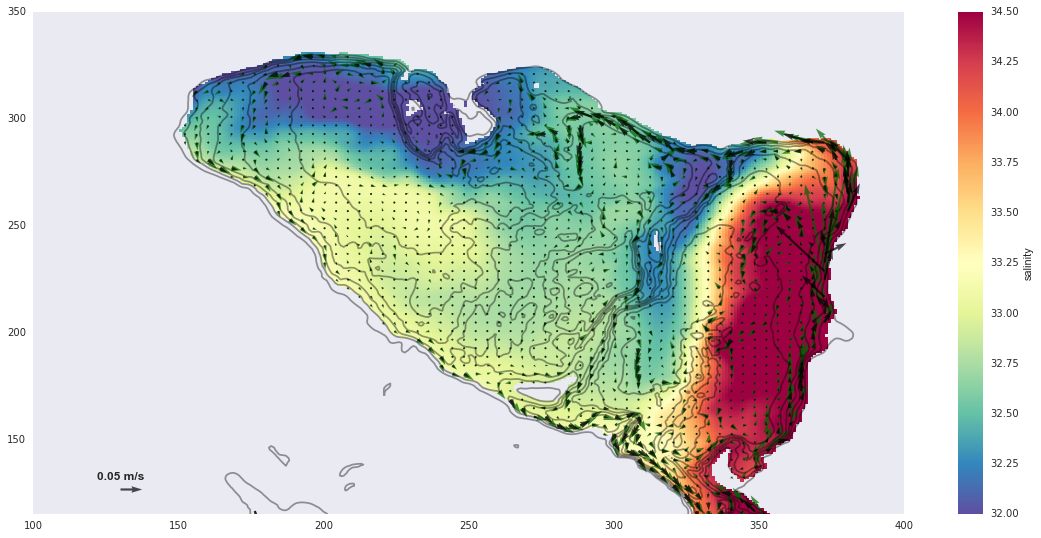

year :2014


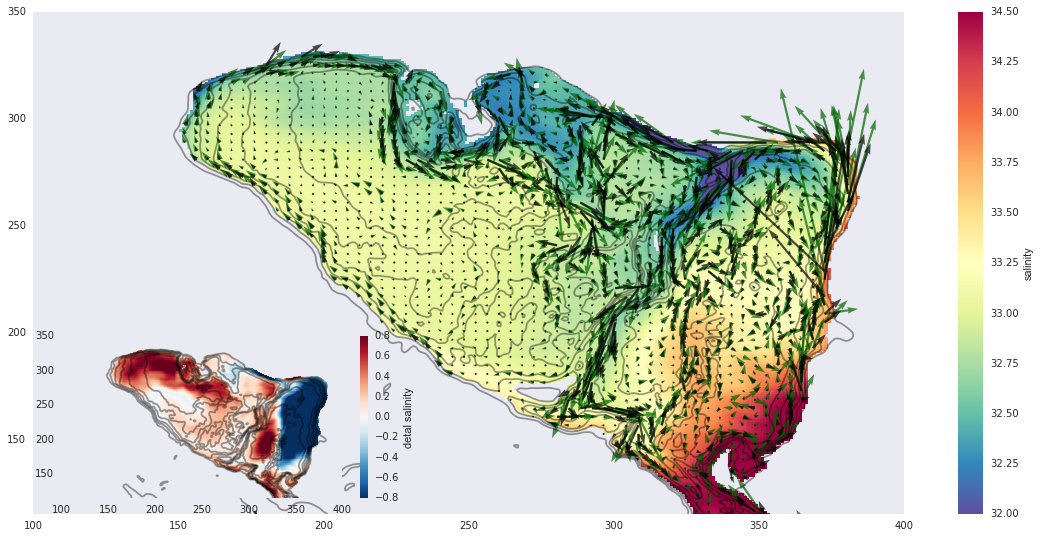

In [57]:


print ('Plot salinity maximum layer with modeled velocity')

T=2002

for year,vmin,vmax in zip ([2002,2014],[8.347e6+1000,8.347e6+1000],[8.347e6+1500,8.347e6+2400]):
    print ("year :%s"%year)
    ug_0,vg_0,P_0,nav_lat,nav_lon = geo.geoflow(\
        modelt=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_t_year%s.nc'%year),
        models=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_s_year%s.nc'%year),
        modelssh=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%year),
        layer=layer,ssh_key = 'True',detail = 'False')


    fig = plt.figure(figsize=(13*1.5,6*1.5))    
    data= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')
    data = np.sum(data[:layer,:,:],axis=0)
    data = np.ma.masked_where(tmask[layer,:,:]==0,data)
    plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer),
               vmin=32,vmax=34.5,cmap='Spectral_r');
    
    cbar=plt.colorbar()
    cbar.set_label('salinity')
    #vector
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.ma.masked_invalid(ug_0[::4,::4]), np.ma.masked_invalid(vg_0[::4,::4]),
               scale=2.,width=0.0025,color='darkgreen',alpha=0.7)

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], u[layer,::4,::4], v[layer,::4,::4],
               scale=2.,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)

    if year ==2002:
        store_s = data[:,:]/layer
    if year ==2014:
        left, bottom, width, height = [0.145, 0.15, 0.25, 0.25]
        ax = fig.add_axes([left, bottom, width, height])
        im=ax.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer-store_s),cmap='RdBu_r',
                   vmin=-0.8,vmax=0.8)
        cbar=fig.colorbar(im, ax=ax)
        cbar.set_label('detal salinity')
        plt.ylim(115,350);plt.xlim(100,400)
        plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.show()


looks like temperature is more dominant in density.. (because the salinity seems to have a negative relationship with density but we know this is not true.)

-- refer to the previous version (http://nbviewer.jupyter.org/urls/bitbucket.org/ccar-modeling/analysis-cindy/raw/aa4f3eba015e99af2aa149ff1e6172ab888a68a8/notebooks/phy_field/two-layer_Arctic.ipynb).
